In [2]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

import os
import warnings

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
plt.rc('text', usetex=True)

from astropy.table import Table, Column, vstack
from astropy.utils.metadata import MergeConflictWarning
warnings.filterwarnings('ignore', category=MergeConflictWarning, append=True)

from astroML.stats import binned_statistic_2d
from scipy.ndimage.filters import gaussian_filter

from halotools.utils import sliding_conditional_percentile

from palettable.tableau import TrafficLight_9
color_cycle = TrafficLight_9.mpl_colors

from asap.utils import rank_splitting_sample, random_cmap
from asap.ellipse_selection_functions import ellipse_split_2d

from dsigma import compute_ds as ds
from dsigma import jackknife as jk
from dsigma import covariance as cov
from dsigma.stack_ds import stack_delta_sigma, batch_delta_sigma
from dsigma.plots import show_delta_sigma_profiles, show_r_delta_sigma, show_single_profile

In [3]:
def stack_with_mask(lens_ds, lens_data, mask_use, rand_ds=None, rand_data=None,
                    n_boots=10000, n_jobs=4, z_bins=8, selection_bias=True, 
                    weight_field='weight'):
    """Stack the DeltaSigma profiles for the selected lenses."""
    lens_ds_use, lens_data_use = lens_ds[mask_use], lens_data[mask_use]

    # Get the stacked profile
    dsig_all, dsig_boot, dsig_jk = cov.get_bootstrap_samples_dsigma(
        lens_ds_use, rand_ds, lens_data_use, rand_data, n_boots=n_boots, n_jobs=n_jobs, 
        z_bins=z_bins, selection_bias=selection_bias, weight_field=weight_field, 
        use_boost=False)

    # Get the covariance matrix
    dsig_cov = np.cov(dsig_boot, rowvar=False)

    # Use the diagnoal terms as uncertainties
    dsig_err = np.sqrt(np.diag(dsig_cov))
    
    return dsig_all, dsig_err


def get_dsigma_mass_box(
    lens_ds, lens_data, boxbin, mask=None, rand_ds=None, rand_data=None, n_boots=10000,
    n_jobs=4, mass1='logm_max', mass2='logm_10'):
    """Generate a mask array for boxbin of mass."""
    min_logm1, max_logm1 = np.nanmin(boxbin[mass1]), np.nanmax(boxbin[mass1])
    min_logm2, max_logm2 = np.nanmin(boxbin[mass2]), np.nanmax(boxbin[mass2])
    
    box_mask = ((lens_data[mass1] >= min_logm1) & (lens_data[mass1] < max_logm1) &
                (lens_data[mass2] >= min_logm2) & (lens_data[mass2] < max_logm2))
    
    if mask is not None:
        mask_use = box_mask & mask
        
    print("# There are %d objects in the boxbin" % mask_use.sum())
    
    dsig, err = stack_with_mask(
        lens_ds, lens_data, mask_use, rand_ds=rand_ds, rand_data=rand_data,
        n_boots=n_boots, n_jobs=n_jobs, z_bins=8, selection_bias=True, 
        weight_field='weight')
    
    return min_logm1, max_logm1, min_logm2, max_logm2, dsig, err


def show_boxbin(logm_max, logm_10, color_arr, cmap=None):
    """Visualize the distribution of galaxies in each aperture mass bins."""
    if cmap is None:
        cmap = random_cmap(ncolors=512)
        
    fig = plt.figure(figsize=(7, 6))
    fig.subplots_adjust(left=0.16, right=0.99, bottom=0.13, top=0.95,
                        wspace=0.00, hspace=0.00)
    ax1 = fig.add_subplot(111)
    ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(25)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)

    ax1.set_xlabel(r'$\log\ (M_{\star,\ \mathrm{Max}}/M_{\odot})$', fontsize=25)
    ax1.set_ylabel(r'$\log\ (M_{\star,\ 10\ \mathrm{kpc}}/M_{\odot})$', fontsize=25)
    
    ax1.scatter(logm_max, logm_10, s=15, alpha=0.6, c=color_arr, cmap=cmap)

    return fig

### New HSC weak lensing results

In [4]:
wl_dir = '/Users/song/data/massive/dr16a/s16a_massive_dsig'

# Lens data
lens_data = np.load(os.path.join(wl_dir, 'lens/s16a_massive_lens_prep_new.npy'))
rand_data = np.load(os.path.join(wl_dir, 'random/s16a_random_500k_prep_new.npy'))

# Pre-compute results
# Medium selection
lens_pre = np.load(os.path.join(wl_dir, 'results/s16a_massive_lens_basic_dsig_pre.npz'))
rand_pre = np.load(os.path.join(wl_dir, 'results/s16a_massive_rand_basic_dsig_pre.npz'))

print(len(lens_data), len(lens_pre['delta_sigma']), len(rand_pre['delta_sigma']))

ds.assert_precompute_catalog_consistent(lens_pre, lens_data)
ds.assert_lens_rand_consistent(lens_pre, rand_pre)

38653 38653 500000


#### Add Jackknife regions

In [5]:
# Number of Jackknife fiedls
njackknife_fields = 31

# Get the pre-compute deltaSigma data, radial bins
lens_ds, radial_bins = lens_pre['delta_sigma'], lens_pre['radial_bins']
rand_ds = rand_pre["delta_sigma"]

lens_ds, rand_ds = jk.add_jackknife_both(lens_ds, rand_ds, njackknife_fields)

#### Select useful galaxies

In [6]:
# The cross-match is done outside 
# The astropy.table.join seems to change the order of the table.
lens_mass = Table.read(os.path.join(wl_dir, 's16a_massive_lens_prep_cog_mask.fits'))

assert np.all(lens_mass['object_id'] == lens_data['object_id'])

#### Separate galaxies into 12 aperture mass bins

0.010869565217391304 0.9891304347826086


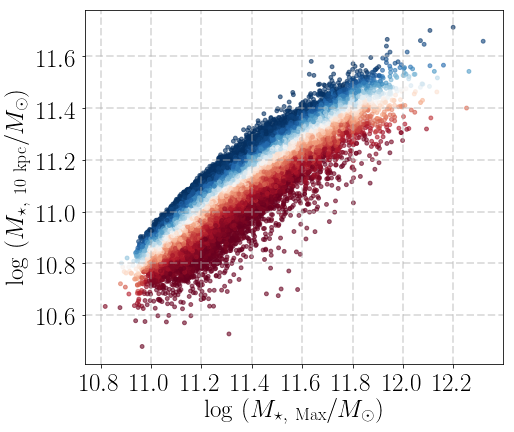

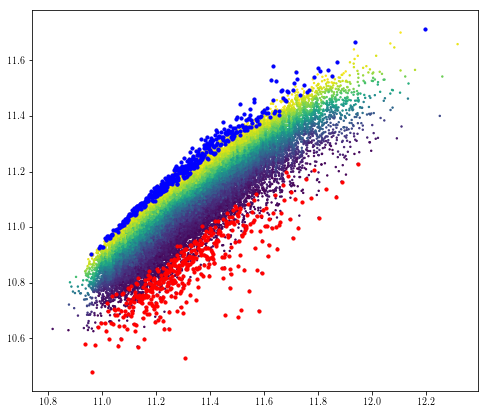

In [7]:
# Rmove the outliers 

logm_10_rank = sliding_conditional_percentile(lens_mass['logm_max'], lens_mass['logm_10'], 
                                              window_length=91, add_subgrid_noise=False)

_ = show_boxbin(lens_mass['logm_max'], lens_mass['logm_10'], logm_10_rank, cmap=plt.cm.RdBu)

print(np.nanmin(logm_10_rank), np.nanmax(logm_10_rank))

low_mask = logm_10_rank <= 0.012
upp_mask = logm_10_rank >= 0.988

# Show the outliers
plt.figure(figsize=(8, 7))

plt.scatter(lens_mass['logm_max'], lens_mass['logm_10'], c=logm_10_rank, s=2)
plt.scatter(lens_mass['logm_max'][low_mask], lens_mass['logm_10'][low_mask], c='r', s=10)
plt.scatter(lens_mass['logm_max'][upp_mask], lens_mass['logm_10'][upp_mask], c='b', s=10)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: TableReplaceWarning: replaced column 'sample_id' which looks like an array slice. The new column no longer shares memory with the original array.
  


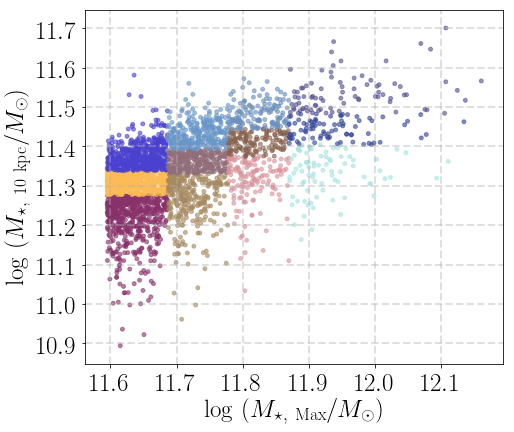

In [8]:
# Based on the ranking of `logm_10`
boxbin_a = rank_splitting_sample(lens_mass, 'logm_max', 'logm_10',
                                 n_bins=3, n_sample=3, X_min=11.595, X_max=11.87)

boxbin_b = rank_splitting_sample(lens_mass, 'logm_max', 'logm_10',
                                 n_bins=1, n_sample=3, X_min=11.87, X_max=12.19)

boxbin_b['sample_id'] += 9

boxbins = vstack([boxbin_a, boxbin_b])

_ = show_boxbin(boxbins['logm_max'], boxbins['logm_10'], boxbins['sample_id'])

### Get the stacked DeltaSigma profiles in each bin

In [9]:
# Define the output array
bin_ids = np.asarray(np.unique(boxbins['sample_id']))

# Exclude the ones with problematic photometry and 1-D profiles
quality_mask = (lens_mass['clean_photometry'] & lens_mass['cog_mask'] & ~low_mask & ~upp_mask)
print(quality_mask.sum(), len(lens_data))


dsigma_box = np.zeros(len(bin_ids), 
                      dtype=[("id", "int32"),
                             ("min_logm1", "float32"), ("max_logm1", "float32"),
                             ("min_logm2", "float32"), ("max_logm2", "float32"),
                             ("r_mpc", "float64", (len(radial_bins))),
                             ("dsigma", "float64", (len(radial_bins),)),
                             ("dsigma_err", "float64", (len(radial_bins),))])

for jj, idx in enumerate(bin_ids):
    results = get_dsigma_mass_box(
        lens_ds, lens_data, boxbins[boxbins['sample_id'] == idx], 
        mask=quality_mask, rand_ds=rand_ds, rand_data=rand_data, 
        n_boots=10000, n_jobs=4, mass1='logm_max', mass2='logm_10')
    
    min_logm1, max_logm1, min_logm2, max_logm2, dsig, err = results
    
    dsigma_box[jj]['id'] == idx
    dsigma_box[jj]['min_logm1'] = min_logm1
    dsigma_box[jj]['max_logm1'] = max_logm1
    dsigma_box[jj]['min_logm2'] = min_logm2
    dsigma_box[jj]['max_logm2'] = max_logm2
    dsigma_box[jj]['r_mpc'] = radial_bins
    dsigma_box[jj]['dsigma'] = dsig
    dsigma_box[jj]['dsigma_err'] = err

37142 38653
# There are 528 objects in the boxbin
# There are 564 objects in the boxbin
# There are 541 objects in the boxbin
# There are 272 objects in the boxbin
# There are 278 objects in the boxbin
# There are 282 objects in the boxbin
# There are 122 objects in the boxbin
# There are 129 objects in the boxbin
# There are 124 objects in the boxbin
# There are 68 objects in the boxbin
# There are 75 objects in the boxbin
# There are 71 objects in the boxbin


In [10]:
# Save the results
out_dir = '/Users/song/Dropbox/work/project/asap/data/s16a_massive_wide2/dsigma'

np.save(os.path.join(out_dir, 's16a_wide2_dsigma_logm11.6_12_bins.npy'), dsigma_box)

### Visulizations

#### Comparison of DeltaSigma profiles in bins with the same logMmax 

Text(0, 0.5, '$\\Delta\\Sigma\\ (M_{\\odot}/\\mathrm{pc}^2)$')

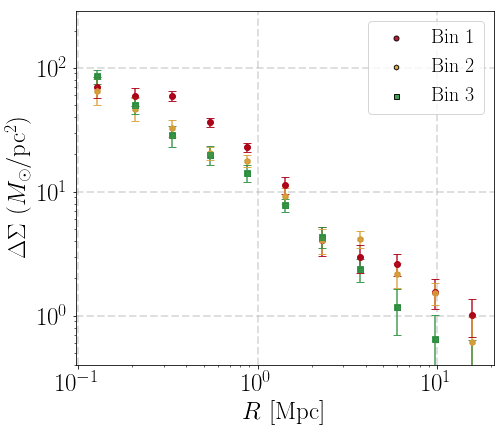

In [78]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.16, right=0.99, bottom=0.13, top=0.95,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

ax1 = show_single_profile(radial_bins, dsigma_box[0]['dsigma'], dsigma_err=dsigma_box[0]['dsigma_err'],
                          ax=ax1, s=25, marker='o', c=color_cycle[0], label=r'$\mathrm{Bin\ 1}$')

ax1 = show_single_profile(radial_bins, dsigma_box[1]['dsigma'], dsigma_err=dsigma_box[1]['dsigma_err'],
                          ax=ax1, s=25, marker='h', c=color_cycle[1], label=r'$\mathrm{Bin\ 2}$')

ax1 = show_single_profile(radial_bins, dsigma_box[2]['dsigma'], dsigma_err=dsigma_box[2]['dsigma_err'],
                          ax=ax1, s=25, marker='s', c=color_cycle[2], label=r'$\mathrm{Bin\ 3}$')

ax1.legend(loc='upper right', fontsize=20)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
ax1.set_ylim(0.4, 289)
    
ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=25)
ax1.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=25)

Text(0, 0.5, '$\\Delta\\Sigma\\ (M_{\\odot}/\\mathrm{pc}^2)$')

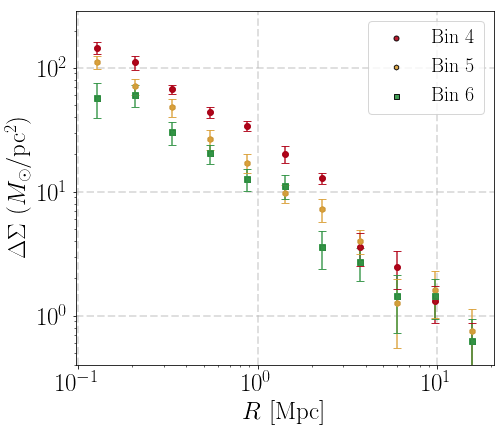

In [79]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.16, right=0.99, bottom=0.13, top=0.95,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

ax1 = show_single_profile(radial_bins, dsigma_box[3]['dsigma'], dsigma_err=dsigma_box[3]['dsigma_err'],
                          ax=ax1, s=25, marker='o', c=color_cycle[0], label=r'$\mathrm{Bin\ 4}$')

ax1 = show_single_profile(radial_bins, dsigma_box[4]['dsigma'], dsigma_err=dsigma_box[4]['dsigma_err'],
                          ax=ax1, s=25, marker='h', c=color_cycle[1], label=r'$\mathrm{Bin\ 5}$')

ax1 = show_single_profile(radial_bins, dsigma_box[5]['dsigma'], dsigma_err=dsigma_box[5]['dsigma_err'],
                          ax=ax1, s=25, marker='s', c=color_cycle[2], label=r'$\mathrm{Bin\ 6}$')

ax1.legend(loc='upper right', fontsize=20)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.set_ylim(0.4, 289)

ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=25)
ax1.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=25)

Text(0, 0.5, '$\\Delta\\Sigma\\ (M_{\\odot}/\\mathrm{pc}^2)$')

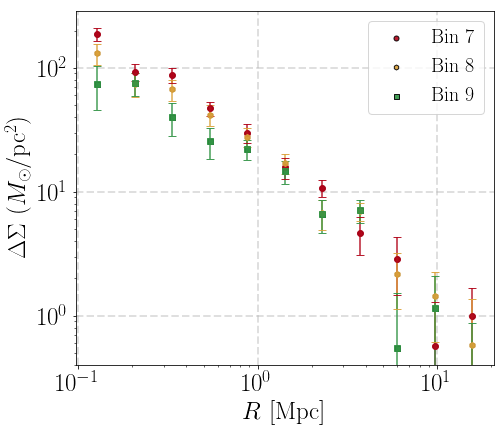

In [80]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.16, right=0.99, bottom=0.13, top=0.95,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

ax1 = show_single_profile(radial_bins, dsigma_box[6]['dsigma'], dsigma_err=dsigma_box[6]['dsigma_err'],
                          ax=ax1, s=25, marker='o', c=color_cycle[0], label=r'$\mathrm{Bin\ 7}$')

ax1 = show_single_profile(radial_bins, dsigma_box[7]['dsigma'], dsigma_err=dsigma_box[7]['dsigma_err'],
                          ax=ax1, s=25, marker='h', c=color_cycle[1], label=r'$\mathrm{Bin\ 8}$')

ax1 = show_single_profile(radial_bins, dsigma_box[8]['dsigma'], dsigma_err=dsigma_box[8]['dsigma_err'],
                          ax=ax1, s=25, marker='s', c=color_cycle[2], label=r'$\mathrm{Bin\ 9}$')

ax1.legend(loc='upper right', fontsize=20)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.set_ylim(0.4, 289)

ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=25)
ax1.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=25)

Text(0, 0.5, '$\\Delta\\Sigma\\ (M_{\\odot}/\\mathrm{pc}^2)$')

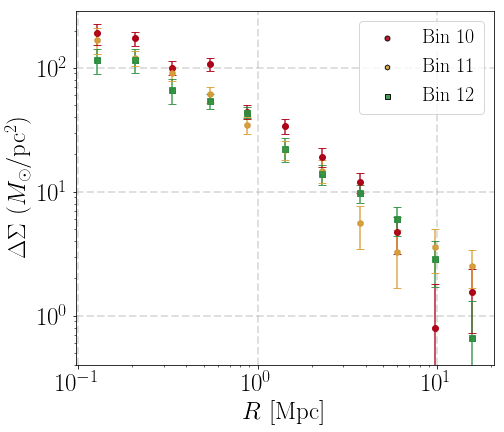

In [81]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.16, right=0.99, bottom=0.13, top=0.95,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

ax1 = show_single_profile(radial_bins, dsigma_box[9]['dsigma'], dsigma_err=dsigma_box[9]['dsigma_err'],
                          ax=ax1, s=25, marker='o', c=color_cycle[0], label=r'$\mathrm{Bin\ 10}$')

ax1 = show_single_profile(radial_bins, dsigma_box[10]['dsigma'], dsigma_err=dsigma_box[10]['dsigma_err'],
                          ax=ax1, s=25, marker='h', c=color_cycle[1], label=r'$\mathrm{Bin\ 11}$')

ax1 = show_single_profile(radial_bins, dsigma_box[11]['dsigma'], dsigma_err=dsigma_box[11]['dsigma_err'],
                          ax=ax1, s=25, marker='s', c=color_cycle[2], label=r'$\mathrm{Bin\ 12}$')

ax1.legend(loc='upper right', fontsize=20)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.set_ylim(0.4, 289)

ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=25)
ax1.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=25)

#### Create a series of plots for making GIF

In [112]:
BLU = plt.cm.Blues
BLK = plt.cm.Greys

for ii in np.arange(12):

    fig = plt.figure(figsize=(13, 9.5))

    fig.subplots_adjust(left=0.109, right=0.995,
                        bottom=0.11, top=0.995,
                        wspace=0.00, hspace=0.00)

    ax1 = fig.add_subplot(111)

    ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(30)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(30)

    ## M100-M10 scatter plot

    x_arr = lens_data['logm_max']
    y_arr = lens_data['logm_10']
    z_arr = np.log10(lens_data['r50_max'])

    z_stats, x_edges, y_edges = binned_statistic_2d(
        x_arr, y_arr, z_arr, np.nanmedian, bins=(85, 40))

    HM = ax1.imshow(z_stats.T, origin='lower',
                    extent=[x_edges[0], x_edges[-1],
                            y_edges[0], y_edges[-1]],
                    vmin=0.4, vmax=1.50, alpha=0.9,
                    aspect='auto', interpolation='nearest',
                    cmap=plt.cm.Oranges)

    ax1.scatter(x_arr, y_arr, s=5, alpha=0.15)

    CT = ax1.contour(x_edges[:-1], y_edges[:-1],
                     gaussian_filter(z_stats.T, 0.2),
                     5, linewidths=2.5,
                     colors=[BLK(0.7), BLK(0.8), BLK(0.9)],
                     extend='neither')
        
    ax1.clabel(CT, inline=1, fontsize=20)

    ## Zoom in to show the delta sigma plot
    axins = inset_axes(ax1, 4.0, 3.0, loc=4, bbox_to_anchor=(0.0, 0.08, 1, 1),
                       bbox_transform=ax1.transAxes,)
    axins.set_facecolor(BLK(0.15))
    axins.set_yscale("log", nonposy='clip')

    axins.set_xticks([np.log10(0.2), np.log10(0.5), np.log10(1.0), np.log10(2.0), np.log10(5.0)])
    axins.set_xticklabels([r'$0.2$', r'$0.5$', r'$1.0$', r'$2.0$', r'$5.0$'])
    axins.axvline(np.log10(1.0), linestyle='--', linewidth=2.5, c=BLK(0.6), alpha=0.8)
                  
    axins.errorbar(np.log10(radial_bins), dsigma_box[ii]['dsigma'], dsigma_box[ii]['dsigma_err'], 
                   fmt='o', color=BLU(0.6), ecolor=BLK(1.0), alpha=0.9, 
                   markersize=11, markeredgecolor=BLK(1.0))
    
    _ = axins.set_xlim(-0.8, 0.99)
    _ = axins.set_ylim(1.09, 259.0)
    
    
    for tick in axins.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)
    for tick in axins.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)

    axins.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}$', size=20)
    axins.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', size=20)
    axins.grid(linestyle='--', linewidth=1, alpha=0.3)

    ax1.add_patch(
        patches.Rectangle(
            (dsigma_box[ii]['min_logm1'], dsigma_box[ii]['min_logm2']),
            (dsigma_box[ii]['max_logm1'] - dsigma_box[ii]['min_logm1']),
            (dsigma_box[ii]['max_logm2'] - dsigma_box[ii]['min_logm2']), 
            alpha=0.3, edgecolor='k', linewidth=2.5))

    _ = ax1.set_xlim(11.49, 12.19)
    _ = ax1.set_ylim(10.81, 11.69)

    _ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=35)
    _ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=35)

    fig.savefig('/Users/song/Desktop/dsig_over_aperture_plane_%d.png' % (ii + 1), dpi=120)
    
    plt.close(fig)

/usr/local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:356: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
